In [1]:
import importlib
import GNN_module.scripts as scripts #only used for on the fly reloads
import torch
import copy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from torch_geometric.nn.models import GAT, GCN
from sklearn.model_selection import ParameterGrid
import numpy as np

from GNN_module.scripts import *
import torch.nn.functional as F
from carbontracker.tracker import CarbonTracker


In [65]:
#Run this to reload the scripts without restarting the kernel
importlib.reload(scripts)
from GNN_module.scripts import *

# IMPORTANT: write requirements file and readme after work is done

# Datasets

In [64]:
dataset_cora = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
dataset_citeseer = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
dataset_pubmed = Planetoid(root='data/Planetoid', name='Pubmed', transform=NormalizeFeatures())

In [81]:
dataset = dataset_cora
data = dataset[0]  # Get the first graph object.
num_epochs = 500
dataset_statistics(dataset)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


# Model initialising

In [82]:
gat = GAT(in_channels=dataset.num_features, hidden_channels=8, num_layers=2, out_channels=dataset.num_classes, heads=8, dropout=0.6, act=F.elu)
optimizer_gat = torch.optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)
gatv2 = GAT(v2 = True, in_channels=dataset.num_features, hidden_channels=8, num_layers=2, out_channels=dataset.num_classes, heads=8, dropout=0.6, act=F.elu)
optimizer_gatv2 = torch.optim.Adam(gatv2.parameters(), lr=0.005, weight_decay=5e-4)
gcn = GCN(in_channels=dataset.num_features, hidden_channels=8, out_channels=dataset.num_classes, num_layers=2, dropout=0.6)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)

criterion = torch.nn.CrossEntropyLoss()

In [83]:
num_params_gat = count_trainable_parameters(gat)
num_params_gatv2 = count_trainable_parameters(gatv2)
num_params_gcn = count_trainable_parameters(gcn)

print(f'Number of trainable parameters in GAT: {num_params_gat}')
print(f'Number of trainable parameters in GATv2: {num_params_gatv2}')
print(f'Number of trainable parameters in GCN: {num_params_gcn}')

Number of trainable parameters in GAT: 12055
Number of trainable parameters in GATv2: 24031
Number of trainable parameters in GCN: 11535


# Training

In [84]:
loss_list_gat = train_model(num_epochs, gat, data, optimizer_gat, criterion)
loss_list_gatv2 = train_model(num_epochs, gatv2, data, optimizer_gatv2, criterion)
loss_list_gcn = train_model(num_epochs, gcn, data, optimizer_gcn, criterion)

Training model...

Training model...0.6751012802124023

Training model...0.6294016838073736



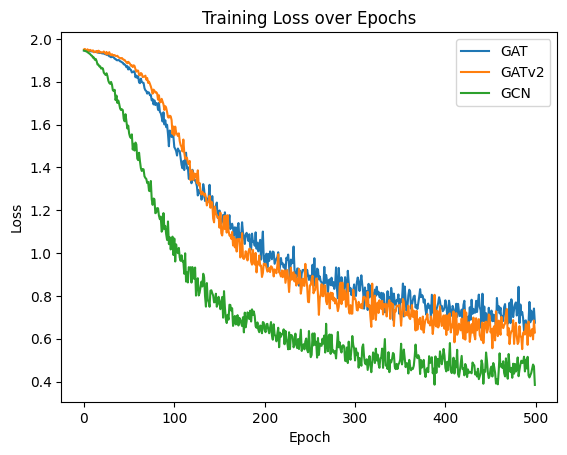

In [85]:
plt.plot(loss_list_gat[:500], label='GAT')
plt.plot(loss_list_gatv2[:500], label='GATv2')
plt.plot(loss_list_gcn[:500], label='GCN')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [86]:
test_model(data.test_mask, gat, dataset), test_model(data.test_mask, gatv2, dataset), test_model(data.test_mask, gcn, dataset)

(0.735, 0.427, 0.722)

# Research ideas





## Robustness of GATs to Adversarial Attacks
### Research Question: 
How robust are Graph Attention Networks to adversarial attacks compared to other GNN architectures?
### Hypothesis:
 GATs, due to their ability to focus on important nodes via attention, are more robust against adversarial attacks than non-attention-based GNNs like Graph Convolutional Networks (GCNs).
### Novelty:
You can simulate simple adversarial attacks (e.g., perturbing node features or edges) and compare the robustness of GATs vs. GCNs or other GNN architectures.



## Transfer Learning with Graph Attention Networks
### Research Question:
Can GATs trained on one type of graph (e.g., a citation network) be effectively transferred to another type (e.g., a social network) using transfer learning?
### Hypothesis:
GATs are more effective for transfer learning between graphs of similar structures (e.g., citation networks to co-authorship networks) compared to graphs with significantly different structures (e.g., citation to biological networks).
### Novelty:
Explore transfer learning in GNNs, specifically GATs, which is less explored. You can train on one graph type, fine-tune on another, and measure performance gains.


# Hyperparameter sweep

In [94]:
#Note that the hidden channels is asa multiplum of number of heads
hyperparameters_gat = {'hidden_channels': [2, 4, 8, 16], 'num_layers': [1, 2, 4, 8], 'heads': [1, 2, 4, 8, 16], 'dropout': [0.0, 0.2, 0.4, 0.6, 0.8]}

In [103]:

sweep = hp_sweep(1, data.val_mask, dataset, hyperparameters_gat, criterion, 'sweep1epoch.pkl')

In [97]:
idx_best = 0
best_acc = 0
for i, test in enumerate(sweep):
    acc = test['test_accuracy']
    if acc > best_acc:
        best_acc = acc
        idx_best = i

In [99]:
sweep[idx_best]['hyperparameters']

{'dropout': 0.2, 'heads': 16, 'hidden_channels': 16, 'num_layers': 8}

# Robustness

We can test robustness to disruptions in the data in a number of ways:

- Adding feature noise (Gaussian noise to each feature or noise acroos entire dataset)
- Adding non existing edges
- Removing edges

## Feature noise

Doing n tests corresponds to repeating the experiment n times
Here we test feature noise robustness. Both for global noise, where we add noise to the feature tensor of the entire graph and local noise where we add noise to the individual feature tensors. Each tests adds noise up to a certain scale. The standard range is from 0 to 0.25 with a step size of 0.01. The noise added is sampled from a normal distribution with zero mean and unit variance.
Doing both n tests, and ploting standard deviation and doing normal tests. If each test is only done once, then the repeats parameter should be set to False

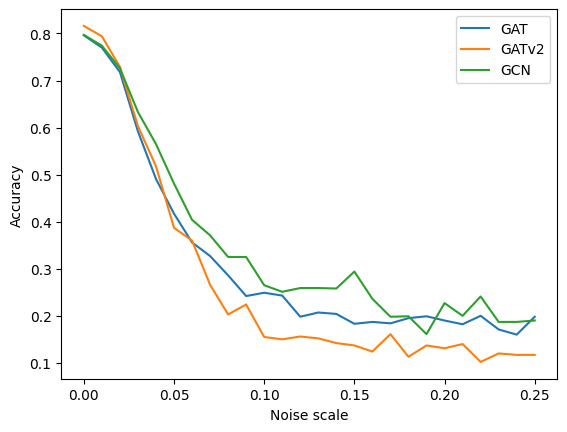

In [87]:
scale, acc_gat = test_feature_noise_robustness(gat, data)
_, acc_gatv2 = test_feature_noise_robustness(gatv2, data)
_, acc_gcn = test_feature_noise_robustness(gcn, data)

tests_not_repeated = np.array([acc_gat, acc_gatv2, acc_gcn])
plot_n_tests(tests_not_repeated, scale, repeating = False, titels=['GAT', 'GATv2', 'GCN'])

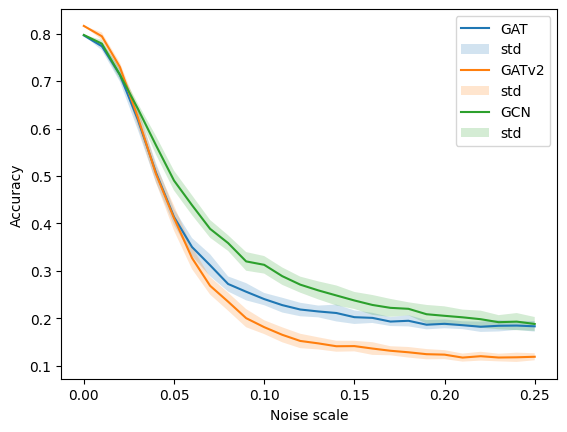

In [89]:
n = 30
scale, test_gcn = do_n_tests(test_feature_noise_robustness, gcn, data, n=n, global_noise = False)
scale, tests_gat = do_n_tests(test_feature_noise_robustness, gat, data, n=n, global_noise=False)
scale, tests_gatv2 = do_n_tests(test_feature_noise_robustness, gatv2, data, n=n, global_noise=False)

tests10 = np.array([tests_gat, tests_gatv2, test_gcn])
plot_n_tests(tests10, scale, titels=['GAT', 'GATv2', 'GCN'])

## Removing edges

In [ ]:
#Not yet implemented

## Adding edges

In [ ]:
#Not yet implemented